<a href="https://colab.research.google.com/github/MrBaten/AutoML/blob/main/efficentNetB1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

dataset_path = os.listdir('/content/drive/MyDrive/pest')

print (dataset_path)  #what kinds of classes are in this dataset

print("Types of classes labels found: ", len(dataset_path))

['aphids', 'mosquito', 'mites', 'sawfly', 'beetle', 'stem_borer', 'armyworm', 'bollworm', 'grasshopper']
Types of classes labels found:  9


In [ ]:
class_labels = []

for item in dataset_path:
 # Get all the file names
 all_classes = os.listdir('/content/drive/MyDrive/pest' + '/' +item)
 #print(all_classes)

 # Add them to the list
 for room in all_classes:
    class_labels.append((item, str('/content/drive/MyDrive/pest' + '/' +item) + '/' + room))
#print(class_labels[:5])

In [ ]:
# Build a dataframe
df = pd.DataFrame(data=class_labels, columns=['Labels', 'image'])
print(df.head())
print(df.tail())

   Labels                                              image
0  aphids  /content/drive/MyDrive/pest/aphids/jpg_58 - Co...
1  aphids  /content/drive/MyDrive/pest/aphids/jpg_78 - Co...
2  aphids  /content/drive/MyDrive/pest/aphids/jpg_45 - Co...
3  aphids      /content/drive/MyDrive/pest/aphids/jpg_32.jpg
4  aphids  /content/drive/MyDrive/pest/aphids/jpg_65 - Co...
           Labels                                              image
2705  grasshopper  /content/drive/MyDrive/pest/grasshopper/jpg_74...
2706  grasshopper  /content/drive/MyDrive/pest/grasshopper/jpg_9 ...
2707  grasshopper  /content/drive/MyDrive/pest/grasshopper/jpg_71...
2708  grasshopper  /content/drive/MyDrive/pest/grasshopper/jpg_67...
2709  grasshopper  /content/drive/MyDrive/pest/grasshopper/jpg_73...


In [ ]:
# Let's check how many samples for each category are present
print("Total number of images in the dataset: ", len(df))

label_count = df['Labels'].value_counts()
print(label_count)

Total number of images in the dataset:  2710
mites          310
aphids         300
mosquito       300
sawfly         300
beetle         300
stem_borer     300
armyworm       300
bollworm       300
grasshopper    300
Name: Labels, dtype: int64


In [ ]:
import cv2
path = '/content/drive/MyDrive/pest/'
dataset_path = os.listdir('/content/drive/MyDrive/pest')

im_size = 240
images = []
labels = []

for i in dataset_path:
    data_path = path + str(i)
    filenames = [i for i in os.listdir(data_path) ]

    for f in filenames:
        img = cv2.imread(data_path + '/' + f)
        img = cv2.resize(img, (im_size, im_size))
        images.append(img)
        labels.append(i)

In [ ]:
#This model takes input images of shape (240, 240, 3), and the input data should range [0, 255].

images = np.array(images)

images = images.astype('float32') / 255.0
images.shape

(2710, 240, 240, 3)

In [ ]:
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
y=df['Labels'].values
print(y)

y_labelencoder = LabelEncoder ()
y = y_labelencoder.fit_transform (y)
print (y)

['aphids' 'aphids' 'aphids' ... 'grasshopper' 'grasshopper' 'grasshopper']
[0 0 0 ... 4 4 4]


In [ ]:
y=y.reshape(-1,1)

from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([('my_ohe', OneHotEncoder(), [0])], remainder='passthrough')
Y = ct.fit_transform(y).toarray()
print(Y[:5])
print(Y[35:])

[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


images, Y = shuffle(images, Y, random_state=1)


train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.05, random_state=415)

#inpect the shape of the training and testing.
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(2574, 240, 240, 3)
(2574, 9)
(136, 240, 240, 3)
(136, 9)


#Rotation augmentation with adam optimizer 1

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=45)
train_datagen.fit(train_x)

train_generator = train_datagen.flow(
    train_x,
    train_y,
    batch_size=32,
    shuffle=True
)

NUM_CLASSES = 9
IMG_SIZE = 240

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Using model without transfer learning
outputs = EfficientNetB1(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

hist = model.fit(
    train_generator,
    steps_per_epoch=len(train_x) // 32,
    epochs=40
)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 9)                6586768   
                                                                 
Total params: 6,586,768
Trainable params: 6,524,713
Non-trainable params: 62,055
_________________________________________________________________
Epoch 1/40
80/80 [==============================] - 121s 551ms/step - loss: 3.3789 - accuracy: 0.1286
Epoch 2/40
80/80 [==============================] - 45s 556ms/step - loss: 2.6264 - accuracy: 0.1656
Epoch 3/40
80/80 [==============================] - 45s 560ms/step - loss: 2.2482 - accuracy: 0.2148
Epoch 4/40
80/80 [==============================] - 46s 568ms/step - loss: 2.1486 - accuracy: 0.2387
Epoch 5/40
80/80 [===================

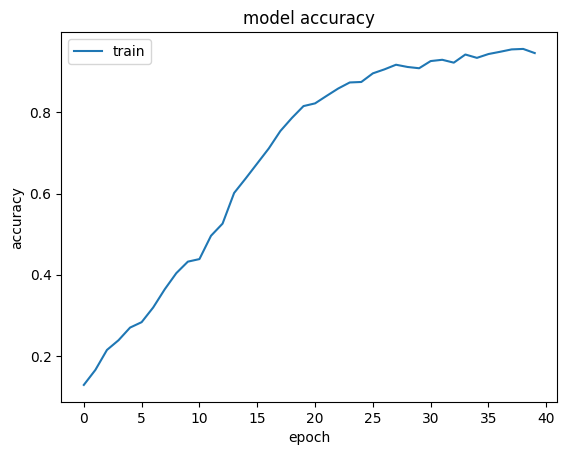

In [ ]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    #plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [ ]:
preds = model.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

5/5 [==============================] - 5s 279ms/step - loss: 0.0743 - accuracy: 0.9853
Loss = 0.07425319403409958
Test Accuracy = 0.9852941036224365


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

test_loss, test_acc = model.evaluate(test_x, test_y)
pred_labels = np.argmax(model.predict(test_x), axis=1)

true_labels = np.argmax(test_y, axis=1)

class_accuracies = []
f1_scores = []
avg_precisions = []
avg_recalls = []

for class_label in range(NUM_CLASSES):
    class_indices = np.where(true_labels == class_label)[0]
    class_pred_labels = pred_labels[class_indices]
    class_true_labels = true_labels[class_indices]

    # Calculate class accuracy
    class_accuracy = np.mean(class_pred_labels == class_true_labels)
    class_accuracies.append(class_accuracy)

    # Calculate F1 score
    class_f1_score = f1_score(class_true_labels, class_pred_labels, pos_label=class_label)
    f1_scores.append(class_f1_score)

    # Calculate precision
    class_precision = precision_score(class_true_labels, class_pred_labels, pos_label=class_label)
    avg_precisions.append(class_precision)

    # Calculate recall
    class_recall = recall_score(class_true_labels, class_pred_labels, pos_label=class_label)
    avg_recalls.append(class_recall)

mean_class_accuracy = np.mean(class_accuracies)
f1_score = np.mean(f1_scores)
mean_precision = np.mean(avg_precisions)
mean_recall = np.mean(avg_recalls)

print("Mean Class Accuracy:", mean_class_accuracy)
print("F1 Score:", f1_score)
print("Mean Average Precision:", mean_precision)
print("Mean Average Recall:", mean_recall)

5/5 [==============================] - 3s 101ms/step
Mean Class Accuracy: 0.988996242619431
F1 Score: 0.9943562610229277
Mean Average Precision: 1.0
Mean Average Recall: 0.988996242619431


# Rotation augmentation with SGD optimizer 2

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=45)
train_datagen.fit(train_x)

train_generator = train_datagen.flow(
    train_x,
    train_y,
    batch_size=32,
    shuffle=True
)

NUM_CLASSES = 9
IMG_SIZE = 240

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Using model without transfer learning
outputs = EfficientNetB1(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)
model_2 = tf.keras.Model(inputs, outputs)
model_2.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])
model_2.summary()

hist = model_2.fit(
    train_generator,
    steps_per_epoch=len(train_x) // 32,
    epochs=40
)


AttributeError: ignored

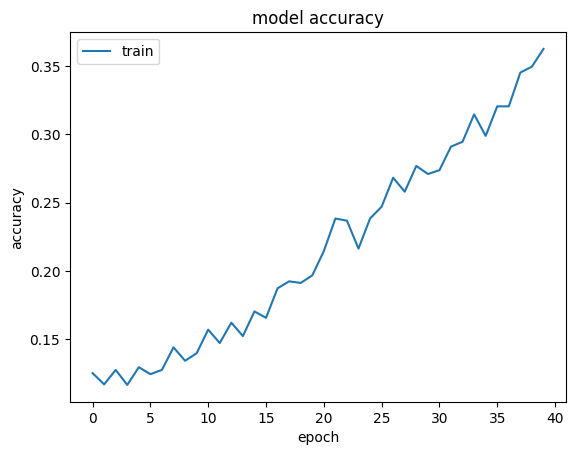

In [ ]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    #plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [ ]:
preds = model_2.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

5/5 [==============================] - 5s 261ms/step - loss: 2.4676 - accuracy: 0.3529
Loss = 2.4676051139831543
Test Accuracy = 0.3529411852359772


####Finding the Mean Class Accuracy,F1 Scores,Average Precision,Average Recall (model 2)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

test_loss, test_acc = model_2.evaluate(test_x, test_y)
pred_labels = np.argmax(model_2.predict(test_x), axis=1)

true_labels = np.argmax(test_y, axis=1)

class_accuracies = []
f1_scores = []
avg_precisions = []
avg_recalls = []

for class_label in range(NUM_CLASSES):
    class_indices = np.where(true_labels == class_label)[0]
    class_pred_labels = pred_labels[class_indices]
    class_true_labels = true_labels[class_indices]

    # Calculate class accuracy
    class_accuracy = np.mean(class_pred_labels == class_true_labels)
    class_accuracies.append(class_accuracy)

    # Calculate F1 score
    class_f1_score = f1_score(class_true_labels, class_pred_labels, labels=[class_label], average=None)
    f1_scores.append(class_f1_score)

    # Calculate precision
    class_precision = precision_score(class_true_labels, class_pred_labels, labels=[class_label], average=None)
    avg_precisions.append(class_precision)

    # Calculate recall
    class_recall = recall_score(class_true_labels, class_pred_labels, labels=[class_label], average=None)
    avg_recalls.append(class_recall)

mean_class_accuracy = np.mean(class_accuracies)
mean_f1_score = np.mean(f1_scores)
mean_precision = np.mean(avg_precisions)
mean_recall = np.mean(avg_recalls)

print("Mean Class Accuracy:", mean_class_accuracy)
print("Mean F1 Score:", mean_f1_score)
print("Mean Average Precision:", mean_precision)
print("Mean Average Recall:", mean_recall)


5/5 [==============================] - 2s 101ms/step
Mean Class Accuracy: 0.38593719753140043
Mean F1 Score: 0.5014220256416496
Mean Average Precision: 0.8888888888888888
Mean Average Recall: 0.38593719753140043


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Rotation augmentation with RMSprop optimizer 3

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=45)
train_datagen.fit(train_x)

train_generator = train_datagen.flow(
    train_x,
    train_y,
    batch_size=32,
    shuffle=True
)

NUM_CLASSES = 9
IMG_SIZE = 240

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Using model without transfer learning
outputs = EfficientNetB1(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)
model_3 = tf.keras.Model(inputs, outputs)

# Create RMSprop optimizer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

model_3.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model_3.summary()

hist = model_3.fit(
    train_generator,
    steps_per_epoch=len(train_x) // 32,
    epochs=40
)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 9)                6586768   
                                                                 
Total params: 6,586,768
Trainable params: 6,524,713
Non-trainable params: 62,055
_________________________________________________________________
Epoch 1/40
80/80 [==============================] - 120s 591ms/step - loss: 3.5600 - accuracy: 0.1196
Epoch 2/40
80/80 [==============================] - 45s 560ms/step - loss: 2.4727 - accuracy: 0.1625
Epoch 3/40
80/80 [==============================] - 46s 567ms/step - loss: 2.2518 - accuracy: 0.2030
Epoch 4/40
80/80 [==============================] - 46s 575ms/step - loss: 2.1209 - accuracy: 0.2439
Epoch 5/40
80/80 [===================

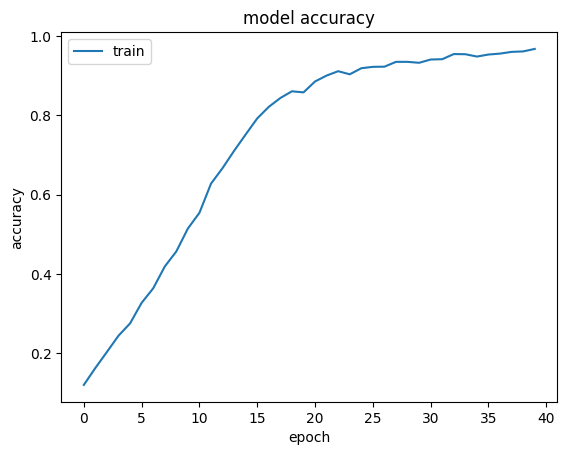

In [ ]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    #plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [ ]:
preds = model_3.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

5/5 [==============================] - 0s 84ms/step - loss: 0.0358 - accuracy: 0.9779
Loss = 0.035772670060396194
Test Accuracy = 0.9779411554336548


####Finding the Mean Class Accuracy,F1 Scores,Average Precision,Average Recall (model 3)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

test_loss, test_acc = model_3.evaluate(test_x, test_y)
pred_labels = np.argmax(model_3.predict(test_x), axis=1)

true_labels = np.argmax(test_y, axis=1)

class_accuracies = []
f1_scores = []
avg_precisions = []
avg_recalls = []

for class_label in range(NUM_CLASSES):
    class_indices = np.where(true_labels == class_label)[0]
    class_pred_labels = pred_labels[class_indices]
    class_true_labels = true_labels[class_indices]

    # Calculate class accuracy
    class_accuracy = np.mean(class_pred_labels == class_true_labels)
    class_accuracies.append(class_accuracy)

    # Calculate F1 score
    class_f1_score = f1_score(class_true_labels, class_pred_labels, pos_label=class_label)
    f1_scores.append(class_f1_score)

    # Calculate precision
    class_precision = precision_score(class_true_labels, class_pred_labels, pos_label=class_label)
    avg_precisions.append(class_precision)

    # Calculate recall
    class_recall = recall_score(class_true_labels, class_pred_labels, pos_label=class_label)
    avg_recalls.append(class_recall)

mean_class_accuracy = np.mean(class_accuracies)
mean_f1_score = np.mean(f1_scores)
mean_precision = np.mean(avg_precisions)
mean_recall = np.mean(avg_recalls)

print("Mean Class Accuracy:", mean_class_accuracy)
print("Mean F1 Score:", mean_f1_score)
print("Mean Average Precision:", mean_precision)
print("Mean Average Recall:", mean_recall)



5/5 [==============================] - 0s 84ms/step
Mean Class Accuracy: 0.9792960662525879
Mean F1 Score: 0.9893004115226337
Mean Average Precision: 1.0
Mean Average Recall: 0.9792960662525879


#Flipping augmentation with adam optimizer (model 4)

In [ ]:
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import tensorflow as tf

NUM_CLASSES = 9
IMG_SIZE = 240

train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True
)
train_datagen.fit(train_x)

train_generator = train_datagen.flow(
    train_x,
    train_y,
    batch_size=32,
    shuffle=True
)

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Using model without transfer learning
outputs = EfficientNetB1(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)

model_4 = tf.keras.Model(inputs, outputs)
model_4.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model_4.summary()

hist = model_4.fit(
    train_generator,
    steps_per_epoch=len(train_x) // 32,
    epochs=40
)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 9)                6586768   
                                                                 
Total params: 6,586,768
Trainable params: 6,524,713
Non-trainable params: 62,055
_________________________________________________________________
Epoch 1/40
80/80 [==============================] - 115s 401ms/step - loss: 3.5296 - accuracy: 0.1294
Epoch 2/40
80/80 [==============================] - 33s 406ms/step - loss: 2.6796 - accuracy: 0.1566
Epoch 3/40
80/80 [==============================] - 33s 410ms/step - loss: 2.3684 - accuracy: 0.1876
Epoch 4/40
80/80 [==============================] - 34s 418ms/step - loss: 2.2577 - accuracy: 0.2152
Epoch 5/40
80/80 [===================

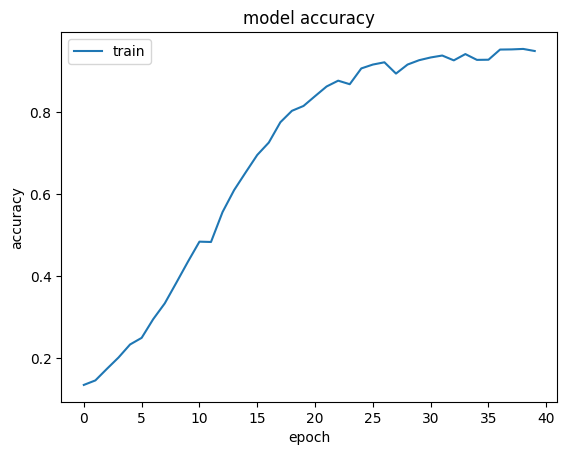

In [ ]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    #plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

In [ ]:
preds = model_4.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

NameError: ignored

Finding the Mean Class Accuracy,F1 Scores,Average Precision,Average Recall (model 4)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

test_loss, test_acc = model_4.evaluate(test_x, test_y)
pred_labels = np.argmax(model_4.predict(test_x), axis=1)

true_labels = np.argmax(test_y, axis=1)

class_accuracies = []
f1_scores = []
avg_precisions = []
avg_recalls = []

for class_label in range(NUM_CLASSES):
    class_indices = np.where(true_labels == class_label)[0]
    class_pred_labels = pred_labels[class_indices]
    class_true_labels = true_labels[class_indices]

    # Calculate class accuracy
    class_accuracy = np.mean(class_pred_labels == class_true_labels)
    class_accuracies.append(class_accuracy)

    # Calculate F1 score
    class_f1_score = f1_score(class_true_labels, class_pred_labels, pos_label=class_label)
    f1_scores.append(class_f1_score)

    # Calculate precision
    class_precision = precision_score(class_true_labels, class_pred_labels, pos_label=class_label)
    avg_precisions.append(class_precision)

    # Calculate recall
    class_recall = recall_score(class_true_labels, class_pred_labels, pos_label=class_label)
    avg_recalls.append(class_recall)

mean_class_accuracy = np.mean(class_accuracies)
mean_f1_score = np.mean(f1_scores)
mean_precision = np.mean(avg_precisions)
mean_recall = np.mean(avg_recalls)

print("Mean Class Accuracy:", mean_class_accuracy)
print("Mean F1 Score:", mean_f1_score)
print("Mean Average Precision:", mean_precision)
print("Mean Average Recall:", mean_recall)


5/5 [==============================] - 2s 98ms/step
Mean Class Accuracy: 1.0
Mean F1 Score: 1.0
Mean Average Precision: 1.0
Mean Average Recall: 1.0


#Flipping augmentation with SGD optimizer (model 5)

In [ ]:
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import tensorflow as tf

NUM_CLASSES = 9
IMG_SIZE = 240

train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True
)
train_datagen.fit(train_x)

train_generator = train_datagen.flow(
    train_x,
    train_y,
    batch_size=32,
    shuffle=True
)

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Using model without transfer learning
outputs = EfficientNetB1(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)

model_5 = tf.keras.Model(inputs, outputs)
model_5.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
model_5.summary()

hist = model_5.fit(
    train_generator,
    steps_per_epoch=len(train_x) // 32,
    epochs=40
)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 9)                6586768   
                                                                 
Total params: 6,586,768
Trainable params: 6,524,713
Non-trainable params: 62,055
_________________________________________________________________
Epoch 1/40
80/80 [==============================] - 62s 421ms/step - loss: 3.0334 - accuracy: 0.1192
Epoch 2/40
80/80 [==============================] - 34s 423ms/step - loss: 2.7986 - accuracy: 0.1208
Epoch 3/40
80/80 [==============================] - 34s 419ms/step - loss: 2.8546 - accuracy: 0.1377
Epoch 4/40
80/80 [==============================] - 34s 421ms/step - loss: 2.6319 - accuracy: 0.1259
Epoch 5/40
80/80 [==================

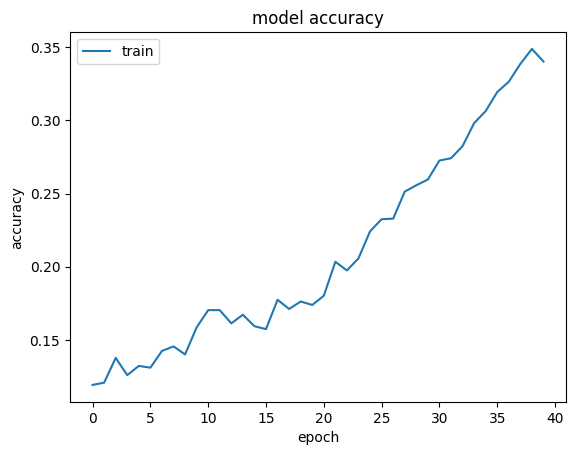

In [ ]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    #plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

In [ ]:
preds = model_5.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

5/5 [==============================] - 2s 85ms/step - loss: 2.5651 - accuracy: 0.2721
Loss = 2.5650577545166016
Test Accuracy = 0.2720588147640228


Finding the Mean Class Accuracy,F1 Scores,Average Precision,Average Recall (model 5)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

test_loss, test_acc = model_5.evaluate(test_x, test_y)
pred_labels = np.argmax(model_5.predict(test_x), axis=1)
true_labels = np.argmax(test_y, axis=1)

class_accuracies = []
avg_precisions = []
avg_recalls = []
f1_scores = []

for class_label in range(NUM_CLASSES):
    class_indices = np.where(true_labels == class_label)[0]
    class_pred_labels = pred_labels[class_indices]
    class_true_labels = true_labels[class_indices]

    # Calculate class accuracy
    class_accuracy = np.mean(class_pred_labels == class_true_labels)
    class_accuracies.append(class_accuracy)

    # Calculate precision
    class_precision = precision_score(class_true_labels, class_pred_labels, average='macro', zero_division=0)
    avg_precisions.append(class_precision)

    # Calculate recall
    class_recall = recall_score(class_true_labels, class_pred_labels, average='macro', zero_division=0)
    avg_recalls.append(class_recall)

    # Calculate F1 score
    class_f1_score = f1_score(class_true_labels, class_pred_labels, average='macro', zero_division=0)
    f1_scores.append(class_f1_score)

mean_class_accuracy = np.mean(class_accuracies)
mean_precision = np.mean(avg_precisions)
mean_recall = np.mean(avg_recalls)
mean_f1_score = np.mean(f1_scores)

print("Mean Class Accuracy:", mean_class_accuracy)
print("Mean F1 Score:", mean_f1_score)
print("Mean Average Precision:", mean_precision)
print("Mean Average Recall:", mean_recall)



5/5 [==============================] - 0s 84ms/step
Mean Class Accuracy: 0.2896619751692215
Mean F1 Score: 0.12454774372387033
Mean Average Precision: 0.26402116402116405
Mean Average Recall: 0.0949331666722971


#Flipping augmentation with RMSprop optimizer (model 6)

In [ ]:
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import tensorflow as tf

NUM_CLASSES = 9
IMG_SIZE = 240

train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True
)
train_datagen.fit(train_x)

train_generator = train_datagen.flow(
    train_x,
    train_y,
    batch_size=32,
    shuffle=True
)

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Using model without transfer learning
outputs = EfficientNetB1(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)

model_6 = tf.keras.Model(inputs, outputs)

# Create RMSprop optimizer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

model_6.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_6.summary()

hist = model_6.fit(
    train_generator,
    steps_per_epoch=len(train_x) // 32,
    epochs=40
)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 9)                6586768   
                                                                 
Total params: 6,586,768
Trainable params: 6,524,713
Non-trainable params: 62,055
_________________________________________________________________
Epoch 1/40
80/80 [==============================] - 84s 416ms/step - loss: 3.5462 - accuracy: 0.1306
Epoch 2/40
80/80 [==============================] - 34s 422ms/step - loss: 2.4397 - accuracy: 0.1790
Epoch 3/40
80/80 [==============================] - 34s 418ms/step - loss: 2.2047 - accuracy: 0.2396
Epoch 4/40
80/80 [==============================] - 34s 420ms/step - loss: 2.0961 - accuracy: 0.2793
Epoch 5/40
80/80 [==================

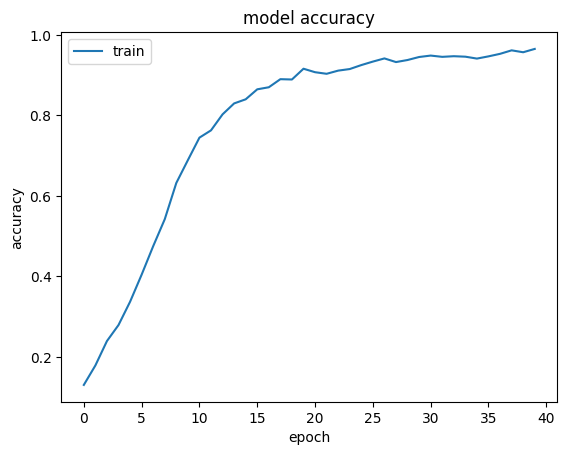

In [ ]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    #plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

In [ ]:
preds = model_6.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

5/5 [==============================] - 1s 92ms/step - loss: 0.0628 - accuracy: 0.9779
Loss = 0.06281973421573639
Test Accuracy = 0.9779411554336548


Finding the Mean Class Accuracy,F1 Scores,Average Precision,Average Recall (model 6)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

test_loss, test_acc = model_6.evaluate(test_x, test_y)
pred_labels = np.argmax(model_6.predict(test_x), axis=1)

true_labels = np.argmax(test_y, axis=1)

class_accuracies = []
f1_scores = []
avg_precisions = []
avg_recalls = []

for class_label in range(NUM_CLASSES):
    class_indices = np.where(true_labels == class_label)[0]
    class_pred_labels = pred_labels[class_indices]
    class_true_labels = true_labels[class_indices]

    # Calculate class accuracy
    class_accuracy = np.mean(class_pred_labels == class_true_labels)
    class_accuracies.append(class_accuracy)

    # Calculate F1 score
    class_f1_score = f1_score(class_true_labels, class_pred_labels, pos_label=class_label)
    f1_scores.append(class_f1_score)

    # Calculate precision
    class_precision = precision_score(class_true_labels, class_pred_labels, pos_label=class_label)
    avg_precisions.append(class_precision)

    # Calculate recall
    class_recall = recall_score(class_true_labels, class_pred_labels, pos_label=class_label)
    avg_recalls.append(class_recall)

mean_class_accuracy = np.mean(class_accuracies)
mean_f1_score = np.mean(f1_scores)
mean_precision = np.mean(avg_precisions)
mean_recall = np.mean(avg_recalls)

print("Mean Class Accuracy:", mean_class_accuracy)
print("Mean F1 Score:", mean_f1_score)
print("Mean Average Precision:", mean_precision)
print("Mean Average Recall:", mean_recall)



5/5 [==============================] - 2s 99ms/step
Mean Class Accuracy: 0.9790123456790124
Mean F1 Score: 0.9891625615763547
Mean Average Precision: 1.0
Mean Average Recall: 0.9790123456790124


#Brightness Augmentation with Adam optimizer (model 7)

In [ ]:
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import tensorflow as tf

NUM_CLASSES = 9
IMG_SIZE = 240

train_datagen = ImageDataGenerator(

    brightness_range=[0.8, 1.2]  # Adjust brightness range for contrast augmentation
)
train_datagen.fit(train_x)

train_generator = train_datagen.flow(
    train_x,
    train_y,
    batch_size=32,
    shuffle=True
)

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Using model without transfer learning
outputs = EfficientNetB1(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)

model_7 = tf.keras.Model(inputs, outputs)
model_7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_7.summary()

hist = model_7.fit(
    train_generator,
    steps_per_epoch=len(train_x) // 32,
    epochs=40
)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 9)                6586768   
                                                                 
Total params: 6,586,768
Trainable params: 6,524,713
Non-trainable params: 62,055
_________________________________________________________________
Epoch 1/40
80/80 [==============================] - 104s 413ms/step - loss: 3.6374 - accuracy: 0.1058
Epoch 2/40
80/80 [==============================] - 33s 411ms/step - loss: 2.8609 - accuracy: 0.1129
Epoch 3/40
80/80 [==============================] - 33s 411ms/step - loss: 2.5778 - accuracy: 0.1176
Epoch 4/40
80/80 [==============================] - 33s 415ms/step - loss: 2.3965 - accuracy: 0.1263
Epoch 5/40
80/80 [=================

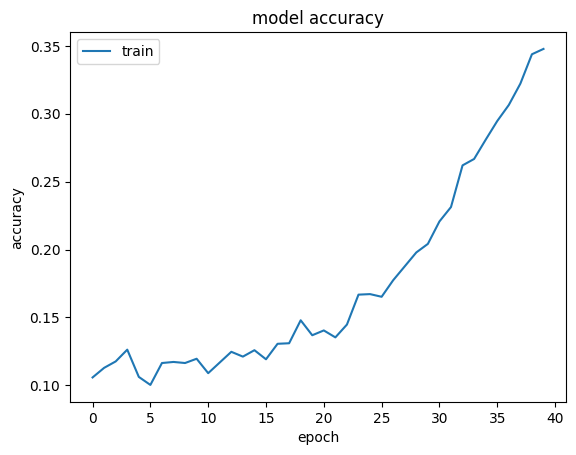

In [ ]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    #plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

In [ ]:
preds = model_7.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

5/5 [==============================] - 6s 93ms/step - loss: 3.5263 - accuracy: 0.2059
Loss = 3.5262858867645264
Test Accuracy = 0.20588235557079315


###Finding the Mean Class Accuracy,F1 Scores,Average Precision,Average Recall (model 7)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

test_loss, test_acc = model_7.evaluate(test_x, test_y)
pred_labels = np.argmax(model_7.predict(test_x), axis=1)

true_labels = np.argmax(test_y, axis=1)

class_accuracies = []
f1_scores = []
avg_precisions = []
avg_recalls = []

for class_label in range(NUM_CLASSES):
    class_indices = np.where(true_labels == class_label)[0]
    class_pred_labels = pred_labels[class_indices]
    class_true_labels = true_labels[class_indices]

    # Calculate class accuracy
    class_accuracy = np.mean(class_pred_labels == class_true_labels)
    class_accuracies.append(class_accuracy)

    # Calculate F1 score
    class_f1_score = f1_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    f1_scores.append(class_f1_score)

    # Calculate precision
    class_precision = precision_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    avg_precisions.append(class_precision)

    # Calculate recall
    class_recall = recall_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    avg_recalls.append(class_recall)

mean_class_accuracy = np.mean(class_accuracies)
mean_f1_score = np.mean(f1_scores)
mean_precision = np.mean(avg_precisions)
mean_recall = np.mean(avg_recalls)

print("Mean Class Accuracy:", mean_class_accuracy)
print("Mean F1 Score:", mean_f1_score)
print("Mean Average Precision:", mean_precision)
print("Mean Average Recall:", mean_recall)


5/5 [==============================] - 3s 100ms/step
Mean Class Accuracy: 0.12250712250712249
Mean F1 Score: 0.17500000000000002
Mean Average Precision: 0.3333333333333333
Mean Average Recall: 0.12250712250712249


#Brightness Augmentation with SGD optimizer (model 8)

In [ ]:
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import tensorflow as tf

NUM_CLASSES = 9
IMG_SIZE = 240

train_datagen = ImageDataGenerator(

    brightness_range=[0.8, 1.2]  # Adjust brightness range for contrast augmentation
)
train_datagen.fit(train_x)

train_generator = train_datagen.flow(
    train_x,
    train_y,
    batch_size=32,
    shuffle=True
)

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Using model without transfer learning
outputs = EfficientNetB1(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)

model_8 = tf.keras.Model(inputs, outputs)
model_8.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model_8.summary()

hist = model_8.fit(
    train_generator,
    steps_per_epoch=len(train_x) // 32,
    epochs=40
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 9)                6586768   
                                                                 
Total params: 6,586,768
Trainable params: 6,524,713
Non-trainable params: 62,055
_________________________________________________________________
Epoch 1/40
80/80 [==============================] - 75s 413ms/step - loss: 3.0639 - accuracy: 0.1129
Epoch 2/40
80/80 [==============================] - 33s 417ms/step - loss: 2.8552 - accuracy: 0.1113
Epoch 3/40
80/80 [==============================] - 35s 434ms/step - loss: 2.8611 - accuracy: 0.1137
Epoch 4/40
80/80 [==============================] - 34s 425ms/step - loss: 2.7881 - accuracy: 0.1090
Epoch 5/40
80/80 [==================

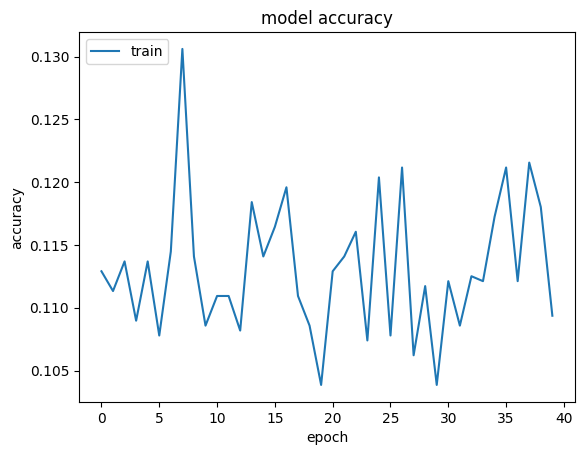

In [ ]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    #plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

In [ ]:
preds = model_8.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

5/5 [==============================] - 4s 278ms/step - loss: 2.2414 - accuracy: 0.1324
Loss = 2.2413644790649414
Test Accuracy = 0.13235294818878174


###Finding the Mean Class Accuracy,F1 Scores,Average Precision,Average Recall (model 8)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

test_loss, test_acc = model_8.evaluate(test_x, test_y)
pred_labels = np.argmax(model_8.predict(test_x), axis=1)

true_labels = np.argmax(test_y, axis=1)

class_accuracies = []
f1_scores = []
avg_precisions = []
avg_recalls = []

for class_label in range(NUM_CLASSES):
    class_indices = np.where(true_labels == class_label)[0]
    class_pred_labels = pred_labels[class_indices]
    class_true_labels = true_labels[class_indices]

    # Calculate class accuracy
    class_accuracy = np.mean(class_pred_labels == class_true_labels)
    class_accuracies.append(class_accuracy)

    # Calculate F1 score
    class_f1_score = f1_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    f1_scores.append(class_f1_score)

    # Calculate precision
    class_precision = precision_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    avg_precisions.append(class_precision)

    # Calculate recall
    class_recall = recall_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    avg_recalls.append(class_recall)

mean_class_accuracy = np.mean(class_accuracies)
mean_f1_score = np.mean(f1_scores)
mean_precision = np.mean(avg_precisions)
mean_recall = np.mean(avg_recalls)

print("Mean Class Accuracy:", mean_class_accuracy)
print("Mean F1 Score:", mean_f1_score)
print("Mean Average Precision:", mean_precision)
print("Mean Average Recall:", mean_recall)


5/5 [==============================] - 0s 86ms/step
Mean Class Accuracy: 0.1210605014952841
Mean F1 Score: 0.1640262271841219
Mean Average Precision: 0.3333333333333333
Mean Average Recall: 0.1210605014952841


#Brightness Augmentation with RMSprop optimizer (model 9)

In [ ]:
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import tensorflow as tf

NUM_CLASSES = 9
IMG_SIZE = 240

train_datagen = ImageDataGenerator(

    brightness_range=[0.8, 1.2]  # Adjust brightness range for contrast augmentation
)
train_datagen.fit(train_x)

train_generator = train_datagen.flow(
    train_x,
    train_y,
    batch_size=32,
    shuffle=True
)

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Using model without transfer learning
outputs = EfficientNetB1(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)

# Create RMSprop optimizer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

model_9 = tf.keras.Model(inputs, outputs)
model_9.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_9.summary()

hist = model_9.fit(
    train_generator,
    steps_per_epoch=len(train_x) // 32,
    epochs=40
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 9)                6586768   
                                                                 
Total params: 6,586,768
Trainable params: 6,524,713
Non-trainable params: 62,055
_________________________________________________________________
Epoch 1/40
80/80 [==============================] - 83s 409ms/step - loss: 3.8044 - accuracy: 0.1192
Epoch 2/40
80/80 [==============================] - 33s 408ms/step - loss: 2.6360 - accuracy: 0.1098
Epoch 3/40
80/80 [==============================] - 33s 408ms/step - loss: 2.3913 - accuracy: 0.1121
Epoch 4/40
80/80 [==============================] - 33s 413ms/step - loss: 2.3215 - accuracy: 0.1149
Epoch 5/40
80/80 [==================

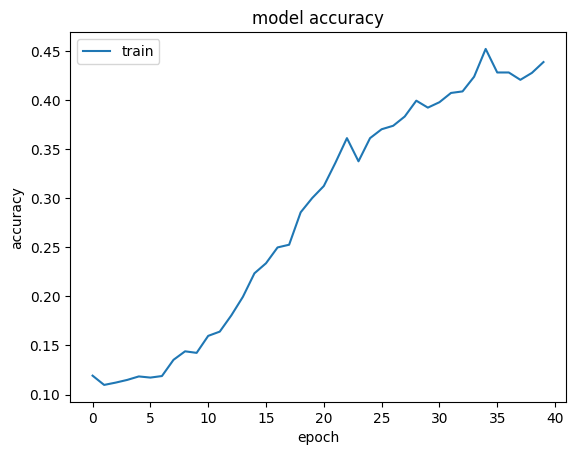

In [ ]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    #plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

In [ ]:
preds = model_9.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

NameError: ignored

###Finding the Mean Class Accuracy,F1 Scores,Average Precision,Average Recall (model 9)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

test_loss, test_acc = model_9.evaluate(test_x, test_y)
pred_labels = np.argmax(model_9.predict(test_x), axis=1)

true_labels = np.argmax(test_y, axis=1)

class_accuracies = []
f1_scores = []
avg_precisions = []
avg_recalls = []

for class_label in range(NUM_CLASSES):
    class_indices = np.where(true_labels == class_label)[0]
    class_pred_labels = pred_labels[class_indices]
    class_true_labels = true_labels[class_indices]

    # Calculate class accuracy
    class_accuracy = np.mean(class_pred_labels == class_true_labels)
    class_accuracies.append(class_accuracy)

    # Calculate F1 score
    class_f1_score = f1_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    f1_scores.append(class_f1_score)

    # Calculate precision
    class_precision = precision_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    avg_precisions.append(class_precision)

    # Calculate recall
    class_recall = recall_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    avg_recalls.append(class_recall)

mean_class_accuracy = np.mean(class_accuracies)
mean_f1_score = np.mean(f1_scores)
mean_precision = np.mean(avg_precisions)
mean_recall = np.mean(avg_recalls)

print("Mean Class Accuracy:", mean_class_accuracy)
print("Mean F1 Score:", mean_f1_score)
print("Mean Average Precision:", mean_precision)
print("Mean Average Recall:", mean_recall)

5/5 [==============================] - 3s 96ms/step
Mean Class Accuracy: 0.10861159774203252
Mean F1 Score: 0.16939196281301547
Mean Average Precision: 0.5555555555555556
Mean Average Recall: 0.10861159774203252


#Cropping Augmentation with Adam optimizer (model 10)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

NUM_CLASSES = 9
IMG_SIZE = 240

# Create ImageDataGenerator with cropping augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    width_shift_range=0.1,  # Adjust the horizontal shift range
    height_shift_range=0.1,  # Adjust the vertical shift range
    zoom_range=0.1,  # Adjust the zoom range
    shear_range=0.1,  # Adjust the shear range
    fill_mode='nearest'  # Use the nearest mode for filling missing pixels
)
train_datagen.fit(train_x)

train_generator = train_datagen.flow(
    train_x,
    train_y,
    batch_size=32,
    shuffle=True
)

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Using model without transfer learning
outputs = EfficientNetB1(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)

# Create RMSprop optimizer

model_10 = tf.keras.Model(inputs, outputs)
model_10.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model_10.summary()

hist = model_10.fit(
    train_generator,
    steps_per_epoch=len(train_x) // 32,
    epochs=40
)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 9)                6586768   
                                                                 
Total params: 6,586,768
Trainable params: 6,524,713
Non-trainable params: 62,055
_________________________________________________________________
Epoch 1/40
80/80 [==============================] - 127s 650ms/step - loss: 3.4891 - accuracy: 0.1459
Epoch 2/40
80/80 [==============================] - 44s 539ms/step - loss: 2.6337 - accuracy: 0.1696
Epoch 3/40
80/80 [==============================] - 45s 555ms/step - loss: 2.3435 - accuracy: 0.1959
Epoch 4/40
80/80 [==============================] - 43s 537ms/step - loss: 2.1734 - accuracy: 0.2482
Epoch 5/40
80/80 [===================

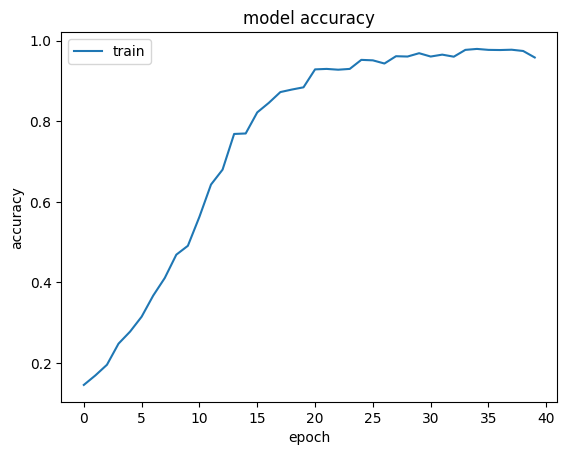

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    #plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

In [ ]:
preds = model_10.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

5/5 [==============================] - 7s 250ms/step - loss: 0.0135 - accuracy: 1.0000
Loss = 0.01352627296000719
Test Accuracy = 1.0


###Finding the Mean Class Accuracy,F1 Scores,Average Precision,Average Recall (model 10)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

test_loss, test_acc = model_10.evaluate(test_x, test_y)
pred_labels = np.argmax(model_10 .predict(test_x), axis=1)

true_labels = np.argmax(test_y, axis=1)

class_accuracies = []
f1_scores = []
avg_precisions = []
avg_recalls = []

for class_label in range(NUM_CLASSES):
    class_indices = np.where(true_labels == class_label)[0]
    class_pred_labels = pred_labels[class_indices]
    class_true_labels = true_labels[class_indices]

    # Calculate class accuracy
    class_accuracy = np.mean(class_pred_labels == class_true_labels)
    class_accuracies.append(class_accuracy)

    # Calculate F1 score
    class_f1_score = f1_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    f1_scores.append(class_f1_score)

    # Calculate precision
    class_precision = precision_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    avg_precisions.append(class_precision)

    # Calculate recall
    class_recall = recall_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    avg_recalls.append(class_recall)

mean_class_accuracy = np.mean(class_accuracies)
mean_f1_score = np.mean(f1_scores)
mean_precision = np.mean(avg_precisions)
mean_recall = np.mean(avg_recalls)

print("Mean Class Accuracy:", mean_class_accuracy)
print("Mean F1 Score:", mean_f1_score)
print("Mean Average Precision:", mean_precision)
print("Mean Average Recall:", mean_recall)

5/5 [==============================] - 2s 103ms/step
Mean Class Accuracy: 1.0
Mean F1 Score: 1.0
Mean Average Precision: 1.0
Mean Average Recall: 1.0


#Cropping Augmentation with SGD optimizer (model 11)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

NUM_CLASSES = 9
IMG_SIZE = 240

# Create ImageDataGenerator with cropping augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    width_shift_range=0.1,  # Adjust the horizontal shift range
    height_shift_range=0.1,  # Adjust the vertical shift range
    zoom_range=0.1,  # Adjust the zoom range
    shear_range=0.1,  # Adjust the shear range
    fill_mode='nearest'  # Use the nearest mode for filling missing pixels
)
train_datagen.fit(train_x)

train_generator = train_datagen.flow(
    train_x,
    train_y,
    batch_size=32,
    shuffle=True
)

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Using model without transfer learning
outputs = EfficientNetB1(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)

# Create RMSprop optimizer

model_11 = tf.keras.Model(inputs, outputs)
model_11.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
model_11.summary()

hist = model_11.fit(
    train_generator,
    steps_per_epoch=len(train_x) // 32,
    epochs=40
)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 9)                6586768   
                                                                 
Total params: 6,586,768
Trainable params: 6,524,713
Non-trainable params: 62,055
_________________________________________________________________
Epoch 1/40
80/80 [==============================] - 96s 672ms/step - loss: 2.9507 - accuracy: 0.1066
Epoch 2/40
80/80 [==============================] - 44s 545ms/step - loss: 2.8031 - accuracy: 0.1353
Epoch 3/40
80/80 [==============================] - 44s 542ms/step - loss: 2.6577 - accuracy: 0.1507
Epoch 4/40
80/80 [==============================] - 45s 554ms/step - loss: 2.5700 - accuracy: 0.1349
Epoch 5/40
80/80 [==================

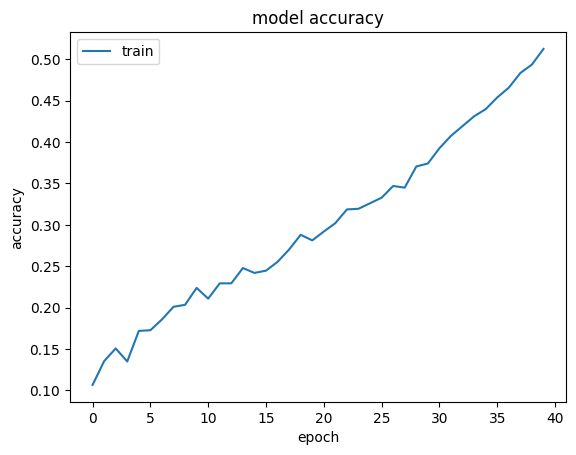

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    #plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

In [ ]:
preds = model_11.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

5/5 [==============================] - 1s 93ms/step - loss: 2.3446 - accuracy: 0.4926
Loss = 2.344590663909912
Test Accuracy = 0.49264705181121826


###Finding the Mean Class Accuracy,F1 Scores,Average Precision,Average Recall (model 11)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

test_loss, test_acc = model_11.evaluate(test_x, test_y)
pred_labels = np.argmax(model_11 .predict(test_x), axis=1)

true_labels = np.argmax(test_y, axis=1)

class_accuracies = []
f1_scores = []
avg_precisions = []
avg_recalls = []

for class_label in range(NUM_CLASSES):
    class_indices = np.where(true_labels == class_label)[0]
    class_pred_labels = pred_labels[class_indices]
    class_true_labels = true_labels[class_indices]

    # Calculate class accuracy
    class_accuracy = np.mean(class_pred_labels == class_true_labels)
    class_accuracies.append(class_accuracy)

    # Calculate F1 score
    class_f1_score = f1_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    f1_scores.append(class_f1_score)

    # Calculate precision
    class_precision = precision_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    avg_precisions.append(class_precision)

    # Calculate recall
    class_recall = recall_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    avg_recalls.append(class_recall)

mean_class_accuracy = np.mean(class_accuracies)
mean_f1_score = np.mean(f1_scores)
mean_precision = np.mean(avg_precisions)
mean_recall = np.mean(avg_recalls)

print("Mean Class Accuracy:", mean_class_accuracy)
print("Mean F1 Score:", mean_f1_score)
print("Mean Average Precision:", mean_precision)
print("Mean Average Recall:", mean_recall)

5/5 [==============================] - 3s 105ms/step
Mean Class Accuracy: 0.47168161950770643
Mean F1 Score: 0.6110559375265258
Mean Average Precision: 1.0
Mean Average Recall: 0.47168161950770643


#Cropping Augmentation with RMSprop optimizer (model 12)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

NUM_CLASSES = 9
IMG_SIZE = 240

# Create ImageDataGenerator with cropping augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    width_shift_range=0.1,  # Adjust the horizontal shift range
    height_shift_range=0.1,  # Adjust the vertical shift range
    zoom_range=0.1,  # Adjust the zoom range
    shear_range=0.1,  # Adjust the shear range
    fill_mode='nearest'  # Use the nearest mode for filling missing pixels
)
train_datagen.fit(train_x)

train_generator = train_datagen.flow(
    train_x,
    train_y,
    batch_size=32,
    shuffle=True
)

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Using model without transfer learning
outputs = EfficientNetB1(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)

# Create RMSprop optimizer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

# Create RMSprop optimizer

model_12 = tf.keras.Model(inputs, outputs)
model_12.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_12.summary()

hist = model_12.fit(
    train_generator,
    steps_per_epoch=len(train_x) // 32,
    epochs=40
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 9)                6586768   
                                                                 
Total params: 6,586,768
Trainable params: 6,524,713
Non-trainable params: 62,055
_________________________________________________________________
Epoch 1/40
80/80 [==============================] - 117s 569ms/step - loss: 3.5503 - accuracy: 0.1298
Epoch 2/40
80/80 [==============================] - 45s 553ms/step - loss: 2.4157 - accuracy: 0.1664
Epoch 3/40
80/80 [==============================] - 43s 541ms/step - loss: 2.2359 - accuracy: 0.2014
Epoch 4/40
80/80 [==============================] - 43s 540ms/step - loss: 2.1211 - accuracy: 0.2589
Epoch 5/40
80/80 [=================

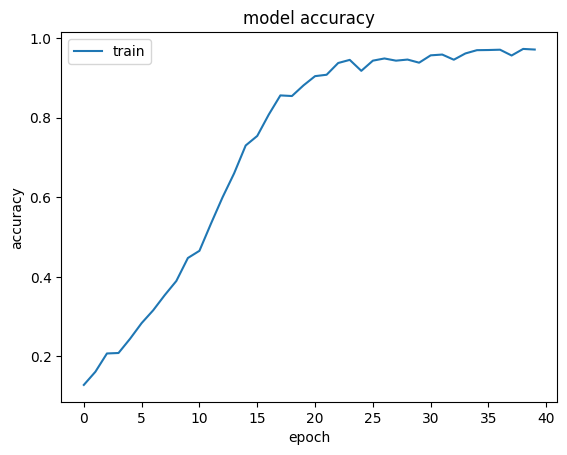

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    #plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

In [ ]:
preds = model_12.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

5/5 [==============================] - 9s 333ms/step - loss: 0.0724 - accuracy: 0.9779
Loss = 0.07242725044488907
Test Accuracy = 0.9779411554336548


###Finding the Mean Class Accuracy,F1 Scores,Average Precision,Average Recall (model 12)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

test_loss, test_acc = model_12.evaluate(test_x, test_y)
pred_labels = np.argmax(model_12 .predict(test_x), axis=1)

true_labels = np.argmax(test_y, axis=1)

class_accuracies = []
f1_scores = []
avg_precisions = []
avg_recalls = []

for class_label in range(NUM_CLASSES):
    class_indices = np.where(true_labels == class_label)[0]
    class_pred_labels = pred_labels[class_indices]
    class_true_labels = true_labels[class_indices]

    # Calculate class accuracy
    class_accuracy = np.mean(class_pred_labels == class_true_labels)
    class_accuracies.append(class_accuracy)

    # Calculate F1 score
    class_f1_score = f1_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    f1_scores.append(class_f1_score)

    # Calculate precision
    class_precision = precision_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    avg_precisions.append(class_precision)

    # Calculate recall
    class_recall = recall_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    avg_recalls.append(class_recall)

mean_class_accuracy = np.mean(class_accuracies)
mean_f1_score = np.mean(f1_scores)
mean_precision = np.mean(avg_precisions)
mean_recall = np.mean(avg_recalls)

print("Mean Class Accuracy:", mean_class_accuracy)
print("Mean F1 Score:", mean_f1_score)
print("Mean Average Precision:", mean_precision)
print("Mean Average Recall:", mean_recall)

5/5 [==============================] - 4s 103ms/step
Mean Class Accuracy: 0.9841269841269842
Mean F1 Score: 0.9914529914529915
Mean Average Precision: 1.0
Mean Average Recall: 0.9841269841269842


# CutOut Augmentation with Adam optimizer (model 13)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import numpy as np

NUM_CLASSES = 9
IMG_SIZE = 240

# Create ImageDataGenerator with cropping augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)
train_datagen.fit(train_x)

# Custom cutout augmentation function
def cutout(image, mask_size):
    mask_value = image.mean()
    image_height, image_width, _ = image.shape
    top = np.random.randint(0, image_height - mask_size)
    left = np.random.randint(0, image_width - mask_size)
    bottom = top + mask_size
    right = left + mask_size
    image[top:bottom, left:right, :] = mask_value
    return image

# Custom preprocessing function with cutout augmentation
def custom_preprocessing(image):
    image = cutout(image, mask_size=16)  # Adjust the mask size as desired
    return image

# Update the preprocessing function of the ImageDataGenerator
train_datagen.preprocessing_function = custom_preprocessing

train_generator = train_datagen.flow(
    train_x,
    train_y,
    batch_size=32,
    shuffle=True
)

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Using model without transfer learning
outputs = EfficientNetB1(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)

# Create RMSprop optimizer

model_13 = tf.keras.Model(inputs, outputs)
model_13.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_13.summary()

hist = model_13.fit(
    train_generator,
    steps_per_epoch=len(train_x) // 32,
    epochs=40
)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 9)                6586768   
                                                                 
Total params: 6,586,768
Trainable params: 6,524,713
Non-trainable params: 62,055
_________________________________________________________________
Epoch 1/40
80/80 [==============================] - 129s 638ms/step - loss: 3.6100 - accuracy: 0.1282
Epoch 2/40
80/80 [==============================] - 61s 753ms/step - loss: 2.7055 - accuracy: 0.1613
Epoch 3/40
80/80 [==============================] - 57s 697ms/step - loss: 2.4403 - accuracy: 0.2073
Epoch 4/40
80/80 [==============================] - 58s 716ms/step - loss: 2.2658 - accuracy: 0.2085
Epoch 5/40
80/80 [=================

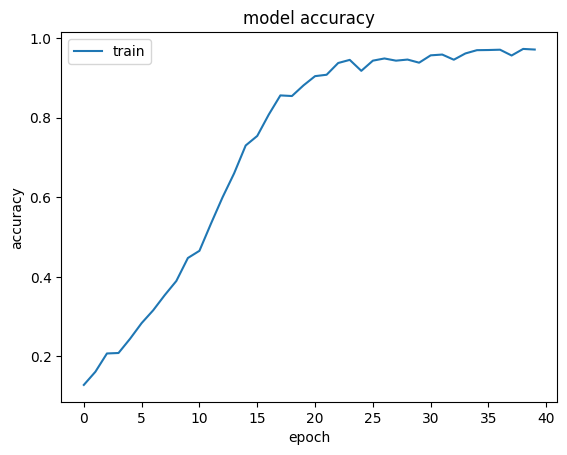

In [ ]:
preds = model_13.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

5/5 [==============================] - 0s 83ms/step - loss: 0.0724 - accuracy: 0.9779
Loss = 0.07242725044488907
Test Accuracy = 0.9779411554336548


### Finding the Mean Class Accuracy,F1 Scores,Average Precision,Average Recall (model 13)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

test_loss, test_acc = model_13.evaluate(test_x, test_y)
pred_labels = np.argmax(model_13 .predict(test_x), axis=1)

true_labels = np.argmax(test_y, axis=1)

class_accuracies = []
f1_scores = []
avg_precisions = []
avg_recalls = []

for class_label in range(NUM_CLASSES):
    class_indices = np.where(true_labels == class_label)[0]
    class_pred_labels = pred_labels[class_indices]
    class_true_labels = true_labels[class_indices]

    # Calculate class accuracy
    class_accuracy = np.mean(class_pred_labels == class_true_labels)
    class_accuracies.append(class_accuracy)

    # Calculate F1 score
    class_f1_score = f1_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    f1_scores.append(class_f1_score)

    # Calculate precision
    class_precision = precision_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    avg_precisions.append(class_precision)

    # Calculate recall
    class_recall = recall_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    avg_recalls.append(class_recall)

mean_class_accuracy = np.mean(class_accuracies)
mean_f1_score = np.mean(f1_scores)
mean_precision = np.mean(avg_precisions)
mean_recall = np.mean(avg_recalls)

print("Mean Class Accuracy:", mean_class_accuracy)
print("Mean F1 Score:", mean_f1_score)
print("Mean Average Precision:", mean_precision)
print("Mean Average Recall:", mean_recall)

5/5 [==============================] - 2s 96ms/step
Mean Class Accuracy: 0.9748677248677249
Mean F1 Score: 0.9866220735785952
Mean Average Precision: 1.0
Mean Average Recall: 0.9748677248677249


# CutOut Augmentation with SGD optimizer (model 14)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import numpy as np

NUM_CLASSES = 9
IMG_SIZE = 240

# Create ImageDataGenerator with cropping augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)
train_datagen.fit(train_x)

# Custom cutout augmentation function
def cutout(image, mask_size):
    mask_value = image.mean()
    image_height, image_width, _ = image.shape
    top = np.random.randint(0, image_height - mask_size)
    left = np.random.randint(0, image_width - mask_size)
    bottom = top + mask_size
    right = left + mask_size
    image[top:bottom, left:right, :] = mask_value
    return image

# Custom preprocessing function with cutout augmentation
def custom_preprocessing(image):
    image = cutout(image, mask_size=16)  # Adjust the mask size as desired
    return image

# Update the preprocessing function of the ImageDataGenerator
train_datagen.preprocessing_function = custom_preprocessing

train_generator = train_datagen.flow(
    train_x,
    train_y,
    batch_size=32,
    shuffle=True
)

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Using model without transfer learning
outputs = EfficientNetB1(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)

# Create RMSprop optimizer

model_14 = tf.keras.Model(inputs, outputs)
model_14.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model_14.summary()

hist = model_14.fit(
    train_generator,
    steps_per_epoch=len(train_x) // 32,
    epochs=40
)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 9)                6586768   
                                                                 
Total params: 6,586,768
Trainable params: 6,524,713
Non-trainable params: 62,055
_________________________________________________________________
Epoch 1/40
80/80 [==============================] - 96s 730ms/step - loss: 3.1276 - accuracy: 0.1125
Epoch 2/40
80/80 [==============================] - 56s 690ms/step - loss: 2.8422 - accuracy: 0.1326
Epoch 3/40
80/80 [==============================] - 46s 574ms/step - loss: 2.7305 - accuracy: 0.1282
Epoch 4/40
80/80 [==============================] - 46s 573ms/step - loss: 2.7552 - accuracy: 0.1353
Epoch 5/40
80/80 [==================

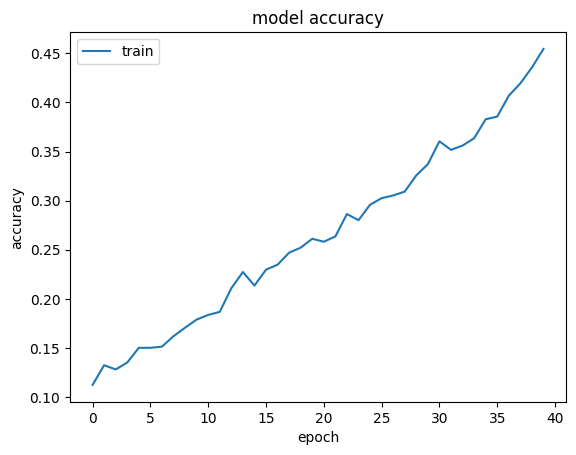

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    #plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

In [ ]:
preds = model_14.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

5/5 [==============================] - 3s 85ms/step - loss: 1.4282 - accuracy: 0.4706
Loss = 1.428154706954956
Test Accuracy = 0.47058823704719543


###Finding the Mean Class Accuracy,F1 Scores,Average Precision,Average Recall (model 14)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

test_loss, test_acc = model_14.evaluate(test_x, test_y)
pred_labels = np.argmax(model_14 .predict(test_x), axis=1)

true_labels = np.argmax(test_y, axis=1)

class_accuracies = []
f1_scores = []
avg_precisions = []
avg_recalls = []

for class_label in range(NUM_CLASSES):
    class_indices = np.where(true_labels == class_label)[0]
    class_pred_labels = pred_labels[class_indices]
    class_true_labels = true_labels[class_indices]

    # Calculate class accuracy
    class_accuracy = np.mean(class_pred_labels == class_true_labels)
    class_accuracies.append(class_accuracy)

    # Calculate F1 score
    class_f1_score = f1_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    f1_scores.append(class_f1_score)

    # Calculate precision
    class_precision = precision_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    avg_precisions.append(class_precision)

    # Calculate recall
    class_recall = recall_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    avg_recalls.append(class_recall)

mean_class_accuracy = np.mean(class_accuracies)
mean_f1_score = np.mean(f1_scores)
mean_precision = np.mean(avg_precisions)
mean_recall = np.mean(avg_recalls)

print("Mean Class Accuracy:", mean_class_accuracy)
print("Mean F1 Score:", mean_f1_score)
print("Mean Average Precision:", mean_precision)
print("Mean Average Recall:", mean_recall)

5/5 [==============================] - 3s 97ms/step
Mean Class Accuracy: 0.4578388868243941
Mean F1 Score: 0.6144398284129967
Mean Average Precision: 1.0
Mean Average Recall: 0.4578388868243941


#CutOut Augmentation with RMSprop optimizer (model 15)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import numpy as np

NUM_CLASSES = 9
IMG_SIZE = 240

# Create ImageDataGenerator with cropping augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)
train_datagen.fit(train_x)

# Custom cutout augmentation function
def cutout(image, mask_size):
    mask_value = image.mean()
    image_height, image_width, _ = image.shape
    top = np.random.randint(0, image_height - mask_size)
    left = np.random.randint(0, image_width - mask_size)
    bottom = top + mask_size
    right = left + mask_size
    image[top:bottom, left:right, :] = mask_value
    return image

# Custom preprocessing function with cutout augmentation
def custom_preprocessing(image):
    image = cutout(image, mask_size=16)  # Adjust the mask size as desired
    return image

# Update the preprocessing function of the ImageDataGenerator
train_datagen.preprocessing_function = custom_preprocessing

train_generator = train_datagen.flow(
    train_x,
    train_y,
    batch_size=32,
    shuffle=True
)

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Using model without transfer learning
outputs = EfficientNetB1(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)

# Create RMSprop optimizer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

model_15 = tf.keras.Model(inputs, outputs)
model_15.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model_15.summary()

hist = model_15.fit(
    train_generator,
    steps_per_epoch=len(train_x) // 32,
    epochs=40
)


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 9)                6586768   
                                                                 
Total params: 6,586,768
Trainable params: 6,524,713
Non-trainable params: 62,055
_________________________________________________________________
Epoch 1/40
80/80 [==============================] - 139s 746ms/step - loss: 3.7615 - accuracy: 0.1400
Epoch 2/40
80/80 [==============================] - 48s 594ms/step - loss: 2.5270 - accuracy: 0.1581
Epoch 3/40
80/80 [==============================] - 47s 587ms/step - loss: 2.2835 - accuracy: 0.1853
Epoch 4/40
80/80 [==============================] - 48s 592ms/step - loss: 2.1411 - accuracy: 0.2313
Epoch 5/40
80/80 [=================

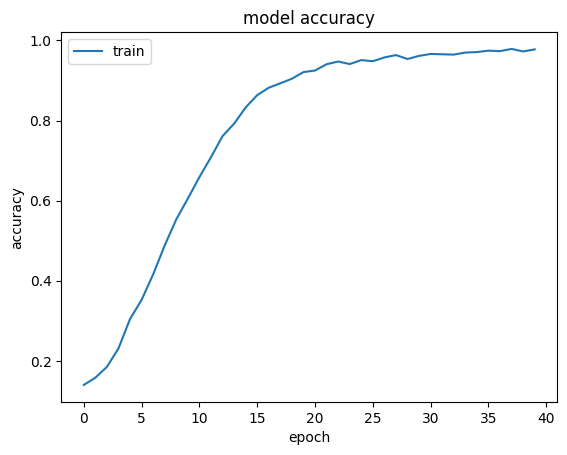

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    #plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

In [ ]:
preds = model_15.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

5/5 [==============================] - 6s 92ms/step - loss: 0.1153 - accuracy: 0.9632
Loss = 0.11528429388999939
Test Accuracy = 0.9632353186607361


###Finding the Mean Class Accuracy,F1 Scores,Average Precision,Average Recall (model 15)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

test_loss, test_acc = model_15.evaluate(test_x, test_y)
pred_labels = np.argmax(model_15.predict(test_x), axis=1)

true_labels = np.argmax(test_y, axis=1)

class_accuracies = []
f1_scores = []
avg_precisions = []
avg_recalls = []

for class_label in range(NUM_CLASSES):
    class_indices = np.where(true_labels == class_label)[0]
    class_pred_labels = pred_labels[class_indices]
    class_true_labels = true_labels[class_indices]

    # Calculate class accuracy
    class_accuracy = np.mean(class_pred_labels == class_true_labels)
    class_accuracies.append(class_accuracy)

    # Calculate F1 score
    class_f1_score = f1_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    f1_scores.append(class_f1_score)

    # Calculate precision
    class_precision = precision_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    avg_precisions.append(class_precision)

    # Calculate recall
    class_recall = recall_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    avg_recalls.append(class_recall)

mean_class_accuracy = np.mean(class_accuracies)
mean_f1_score = np.mean(f1_scores)
mean_precision = np.mean(avg_precisions)
mean_recall = np.mean(avg_recalls)

print("Mean Class Accuracy:", mean_class_accuracy)
print("Mean F1 Score:", mean_f1_score)
print("Mean Average Precision:", mean_precision)
print("Mean Average Recall:", mean_recall)

5/5 [==============================] - 2s 98ms/step
Mean Class Accuracy: 0.9676818082615184
Mean F1 Score: 0.9832152209929989
Mean Average Precision: 1.0
Mean Average Recall: 0.9676818082615184


# Contrast augmentation with AdaM optimizer (model 16)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def gamma_contrast_augmentation(image):
    # Apply gamma contrast augmentation
    gamma = tf.random.uniform([], 0.8, 1.2)
    image = tf.pow(image, gamma)
    return image

train_datagen = ImageDataGenerator(
    preprocessing_function=gamma_contrast_augmentation,
    rotation_range=45
)
train_datagen.fit(train_x)

train_generator = train_datagen.flow(
    train_x,
    train_y,
    batch_size=32,
    shuffle=True
)

NUM_CLASSES = 9
IMG_SIZE = 240

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Using model without transfer learning
outputs = EfficientNetB1(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)
model_16 = tf.keras.Model(inputs, outputs)
model_16.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model_16.summary()

hist = model_16.fit(
    train_generator,
    steps_per_epoch=len(train_x) // 32,
    epochs=40
)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 9)                6586768   
                                                                 
Total params: 6,586,768
Trainable params: 6,524,713
Non-trainable params: 62,055
_________________________________________________________________
Epoch 1/40
80/80 [==============================] - 146s 856ms/step - loss: 3.5342 - accuracy: 0.1424
Epoch 2/40
80/80 [==============================] - 69s 866ms/step - loss: 2.7273 - accuracy: 0.1699
Epoch 3/40
80/80 [==============================] - 69s 861ms/step - loss: 2.3891 - accuracy: 0.1979
Epoch 4/40
80/80 [==============================] - 68s 849ms/step - loss: 2.1933 - accuracy: 0.2474
Epoch 5/40
80/80 [===================

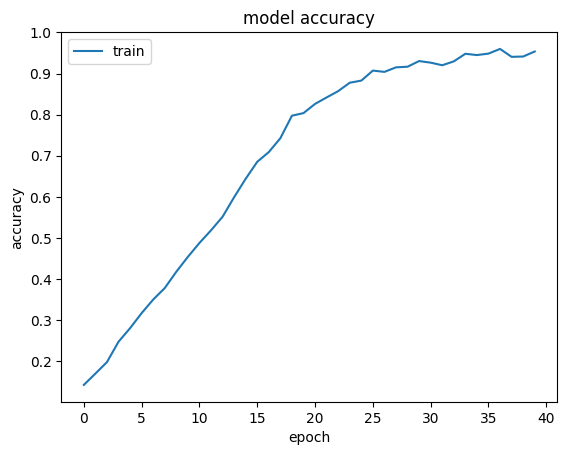

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    #plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

In [ ]:
preds = model_16.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

5/5 [==============================] - 13s 470ms/step - loss: 0.0771 - accuracy: 0.9779
Loss = 0.07710959017276764
Test Accuracy = 0.9779411554336548


###Finding the Mean Class Accuracy,F1 Scores,Average Precision,Average Recall (model 16)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

test_loss, test_acc = model_16.evaluate(test_x, test_y)
pred_labels = np.argmax(model_16.predict(test_x), axis=1)

true_labels = np.argmax(test_y, axis=1)

class_accuracies = []
f1_scores = []
avg_precisions = []
avg_recalls = []

for class_label in range(NUM_CLASSES):
    class_indices = np.where(true_labels == class_label)[0]
    class_pred_labels = pred_labels[class_indices]
    class_true_labels = true_labels[class_indices]

    # Calculate class accuracy
    class_accuracy = np.mean(class_pred_labels == class_true_labels)
    class_accuracies.append(class_accuracy)

    # Calculate F1 score
    class_f1_score = f1_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    f1_scores.append(class_f1_score)

    # Calculate precision
    class_precision = precision_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    avg_precisions.append(class_precision)

    # Calculate recall
    class_recall = recall_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    avg_recalls.append(class_recall)

mean_class_accuracy = np.mean(class_accuracies)
mean_f1_score = np.mean(f1_scores)
mean_precision = np.mean(avg_precisions)
mean_recall = np.mean(avg_recalls)

print("Mean Class Accuracy:", mean_class_accuracy)
print("Mean F1 Score:", mean_f1_score)
print("Mean Average Precision:", mean_precision)
print("Mean Average Recall:", mean_recall)

5/5 [==============================] - 7s 99ms/step
Mean Class Accuracy: 0.9753086419753088
Mean F1 Score: 0.9867243867243867
Mean Average Precision: 1.0
Mean Average Recall: 0.9753086419753088


# Contrast augmentation with SDG optimizer (model 17)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def gamma_contrast_augmentation(image):
    # Apply gamma contrast augmentation
    gamma = tf.random.uniform([], 0.8, 1.2)
    image = tf.pow(image, gamma)
    return image

train_datagen = ImageDataGenerator(
    preprocessing_function=gamma_contrast_augmentation,
    rotation_range=45
)
train_datagen.fit(train_x)

train_generator = train_datagen.flow(
    train_x,
    train_y,
    batch_size=32,
    shuffle=True
)

NUM_CLASSES = 9
IMG_SIZE = 240

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Using model without transfer learning
outputs = EfficientNetB1(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)
model_17 = tf.keras.Model(inputs, outputs)
model_17.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])
model_17.summary()

hist = model_17.fit(
    train_generator,
    steps_per_epoch=len(train_x) // 32,
    epochs=40
)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 9)                6586768   
                                                                 
Total params: 6,586,768
Trainable params: 6,524,713
Non-trainable params: 62,055
_________________________________________________________________
Epoch 1/40
80/80 [==============================] - 105s 881ms/step - loss: 2.9913 - accuracy: 0.1385
Epoch 2/40
80/80 [==============================] - 72s 894ms/step - loss: 2.8790 - accuracy: 0.1259
Epoch 3/40
80/80 [==============================] - 71s 890ms/step - loss: 2.7539 - accuracy: 0.1424
Epoch 4/40
80/80 [==============================] - 72s 898ms/step - loss: 2.6188 - accuracy: 0.1361
Epoch 5/40
80/80 [=================

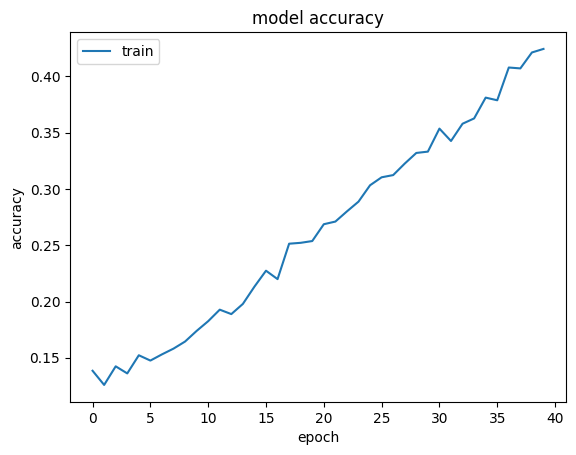

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    #plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

In [ ]:
preds = model_17.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

5/5 [==============================] - 5s 114ms/step - loss: 1.6079 - accuracy: 0.3750
Loss = 1.6078647375106812
Test Accuracy = 0.375


###Finding the Mean Class Accuracy,F1 Scores,Average Precision,Average Recall (model 17)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

test_loss, test_acc = model_17.evaluate(test_x, test_y)
pred_labels = np.argmax(model_17.predict(test_x), axis=1)

true_labels = np.argmax(test_y, axis=1)

class_accuracies = []
f1_scores = []
avg_precisions = []
avg_recalls = []

for class_label in range(NUM_CLASSES):
    class_indices = np.where(true_labels == class_label)[0]
    class_pred_labels = pred_labels[class_indices]
    class_true_labels = true_labels[class_indices]

    # Calculate class accuracy
    class_accuracy = np.mean(class_pred_labels == class_true_labels)
    class_accuracies.append(class_accuracy)

    # Calculate F1 score
    class_f1_score = f1_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    f1_scores.append(class_f1_score)

    # Calculate precision
    class_precision = precision_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    avg_precisions.append(class_precision)

    # Calculate recall
    class_recall = recall_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    avg_recalls.append(class_recall)

mean_class_accuracy = np.mean(class_accuracies)
mean_f1_score = np.mean(f1_scores)
mean_precision = np.mean(avg_precisions)
mean_recall = np.mean(avg_recalls)

print("Mean Class Accuracy:", mean_class_accuracy)
print("Mean F1 Score:", mean_f1_score)
print("Mean Average Precision:", mean_precision)
print("Mean Average Recall:", mean_recall)

5/5 [==============================] - 6s 109ms/step
Mean Class Accuracy: 0.35176425828599744
Mean F1 Score: 0.4824203755576305
Mean Average Precision: 1.0
Mean Average Recall: 0.35176425828599744


# Contrast augmentation with RMS optimizer (model 18)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def gamma_contrast_augmentation(image):
    # Apply gamma contrast augmentation
    gamma = tf.random.uniform([], 0.8, 1.2)
    image = tf.pow(image, gamma)
    return image

train_datagen = ImageDataGenerator(
    preprocessing_function=gamma_contrast_augmentation,
    rotation_range=45
)
train_datagen.fit(train_x)

train_generator = train_datagen.flow(
    train_x,
    train_y,
    batch_size=32,
    shuffle=True
)

NUM_CLASSES = 9
IMG_SIZE = 240

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Using model without transfer learning
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

outputs = EfficientNetB1(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)
model_18 = tf.keras.Model(inputs, outputs)
model_18.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model_18.summary()

hist = model_18.fit(
    train_generator,
    steps_per_epoch=len(train_x) // 32,
    epochs=40
)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 efficientnetb1 (Functional)  (None, 9)                6586768   
                                                                 
Total params: 6,586,768
Trainable params: 6,524,713
Non-trainable params: 62,055
_________________________________________________________________
Epoch 1/40
80/80 [==============================] - 124s 801ms/step - loss: 3.6364 - accuracy: 0.1294
Epoch 2/40
80/80 [==============================] - 65s 808ms/step - loss: 2.4484 - accuracy: 0.1774
Epoch 3/40
80/80 [==============================] - 65s 808ms/step - loss: 2.2851 - accuracy: 0.1979
Epoch 4/40
80/80 [==============================] - 66s 819ms/step - loss: 2.1333 - accuracy: 0.2211
Epoch 5/40
80/80 [===================

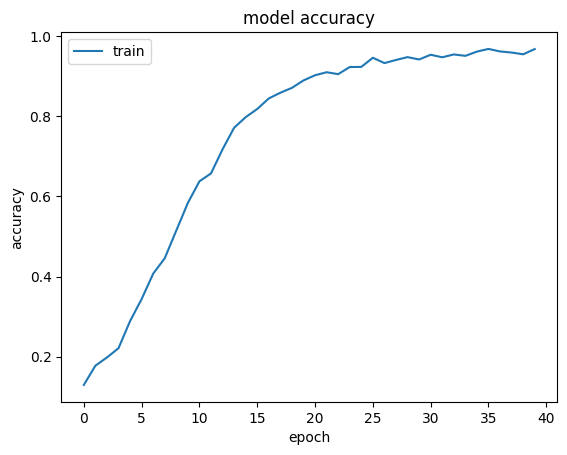

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    #plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

In [ ]:
preds = model_18.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

5/5 [==============================] - 6s 281ms/step - loss: 0.0262 - accuracy: 0.9853
Loss = 0.026171056553721428
Test Accuracy = 0.9852941036224365


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

test_loss, test_acc = model_18.evaluate(test_x, test_y)
pred_labels = np.argmax(model_18.predict(test_x), axis=1)

true_labels = np.argmax(test_y, axis=1)

class_accuracies = []
f1_scores = []
avg_precisions = []
avg_recalls = []

for class_label in range(NUM_CLASSES):
    class_indices = np.where(true_labels == class_label)[0]
    class_pred_labels = pred_labels[class_indices]
    class_true_labels = true_labels[class_indices]

    # Calculate class accuracy
    class_accuracy = np.mean(class_pred_labels == class_true_labels)
    class_accuracies.append(class_accuracy)

    # Calculate F1 score
    class_f1_score = f1_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    f1_scores.append(class_f1_score)

    # Calculate precision
    class_precision = precision_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    avg_precisions.append(class_precision)

    # Calculate recall
    class_recall = recall_score(class_true_labels, class_pred_labels, average='weighted', zero_division=0)
    avg_recalls.append(class_recall)

mean_class_accuracy = np.mean(class_accuracies)
mean_f1_score = np.mean(f1_scores)
mean_precision = np.mean(avg_precisions)
mean_recall = np.mean(avg_recalls)

print("Mean Class Accuracy:", mean_class_accuracy)
print("Mean F1 Score:", mean_f1_score)
print("Mean Average Precision:", mean_precision)
print("Mean Average Recall:", mean_recall)

5/5 [==============================] - 4s 110ms/step
Mean Class Accuracy: 0.9828042328042328
Mean F1 Score: 0.9910538557881553
Mean Average Precision: 1.0
Mean Average Recall: 0.9828042328042328
